In [1]:
#!pip install nltk

In [2]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
get_tokens_list = lambda x: literal_eval(x) if type(x) == str else []
to_list = lambda string: string.split(", ") if type(string) == str else []

In [3]:
nltk.download('popular')
# Compare to tokens with no cleaning
# df_tokens = pd.DataFrame.from_dict(nltk.FreqDist(tokens), orient='index')
# df_tokens.columns = ['Frequency']
# df_tokens.index.name = 'Term'

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/fabien/nltk_data...
[nltk_data]    |   Package movie_reviews is already

True

# Init exploration about reviews table and normalize rate on 100

In [4]:
link = "./rotten_tomatoes_critic_reviews_tokens.csv"
link2 ='./rotten_tomatoes_movies.csv'
# method to convert format rate 3/5 to float
def get_score(rate):
    if type(rate) == str:
        r = rate.split("/")[0]
        if len(r) > 0:
            return float(r)

critic_reviews = pd.read_csv(link, converters={'review_date': pd.to_datetime})
movies = pd.read_csv(link2, converters={'original_release_date': pd.to_datetime, 'streaming_release_date': pd.to_datetime})

In [5]:
critic_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Unnamed: 0            1130017 non-null  int64         
 1   rotten_tomatoes_link  1130017 non-null  object        
 2   critic_name           1111488 non-null  object        
 3   top_critic            1130017 non-null  bool          
 4   publisher_name        1130017 non-null  object        
 5   review_type           1130017 non-null  object        
 6   review_score          824081 non-null   object        
 7   review_date           1130017 non-null  datetime64[ns]
 8   review_content        1064211 non-null  object        
 9   review_score_float    777569 non-null   float64       
 10  tokens                1064211 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 87.3+ MB


In [6]:
critic_reviews.head(1)

Unnamed: 0 rotten_tomatoes_link      critic_name  top_critic  \
0           0            m/0814255  Andrew L. Urban       False   

   publisher_name review_type review_score review_date  \
0  Urban Cinefile       Fresh          NaN  2010-02-06   

                                      review_content  review_score_float  \
0  A fantasy adventure that fuses Greek mythology...                 NaN   

                                              tokens  
0  ['a', 'fantasy', 'adventure', 'that', 'fuses',...

In [7]:
def get_score(x):
    x = x.replace(" ", "")
    letters = {"A":14, "B":11, "C":8,"D":5,"E":2, "F":0}
        #convert string "3.4/5" or "67/100" to rate on 100
    if (type(x)==str) and ('/' in x) and (float(x.split("/")[1]) > float(x.split("/")[0])):
        return 100*(float(x.split("/")[0]) / float(x.split("/")[1]))
    elif x[0] in letters.keys():
        #convert letters rate to rate on 100
        return 100*((letters[x[0]] + 44 - ord(x[1]) if len(x)>1 and x[1] in "-+" else letters[x[0]])/15)

critic_reviews["review_score_float"] = critic_reviews[critic_reviews["review_score"].isna()==False]["review_score"].apply(get_score)
critic_reviews[critic_reviews["review_score_float"].isna()==False]["review_score_float"]

3          70.000000
6          25.000000
7          70.000000
8          73.333333
9          60.000000
             ...    
1130012    40.000000
1130013    70.000000
1130014    80.000000
1130015    70.000000
1130016    53.333333
Name: review_score_float, Length: 777569, dtype: float64

In [8]:
critic_reviews[(critic_reviews["review_score"].isna() != True) | (critic_reviews["review_score_float"].isna() != True)][["review_score", "review_score_float"]]

review_score  review_score_float
3              3.5/5           70.000000
6                1/4           25.000000
7              3.5/5           70.000000
8                  B           73.333333
9                3/5           60.000000
...              ...                 ...
1130012          2/5           40.000000
1130013        3.5/5           70.000000
1130014           B+           80.000000
1130015        3.5/5           70.000000
1130016            C           53.333333

[824081 rows x 2 columns]

In [9]:
critic_reviews.describe()

Unnamed: 0  review_score_float
count  1.130017e+06       777569.000000
mean   5.650080e+05           61.542096
std    3.262080e+05           19.459735
min    0.000000e+00            0.000000
25%    2.825040e+05           50.000000
50%    5.650080e+05           62.500000
75%    8.475120e+05           80.000000
max    1.130016e+06           99.900000

In [10]:
# Check why value max is 900
critic_reviews[critic_reviews["review_score_float"] > 100]

Empty DataFrame
Columns: [Unnamed: 0, rotten_tomatoes_link, critic_name, top_critic, publisher_name, review_type, review_score, review_date, review_content, review_score_float, tokens]
Index: []

# Analyse movie table and compare rate from audience and tomatoemeter

In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rotten_tomatoes_link              17712 non-null  object        
 1   movie_title                       17712 non-null  object        
 2   movie_info                        17391 non-null  object        
 3   critics_consensus                 9134 non-null   object        
 4   content_rating                    17712 non-null  object        
 5   genres                            17693 non-null  object        
 6   directors                         17518 non-null  object        
 7   authors                           16170 non-null  object        
 8   actors                            17360 non-null  object        
 9   original_release_date             16546 non-null  datetime64[ns]
 10  streaming_release_date            17328 non-nu

In [12]:
movies.describe()

runtime  tomatometer_rating  tomatometer_count  audience_rating  \
count  17398.000000        17668.000000       17668.000000     17416.000000   
mean     102.214048           60.884763          57.139801        60.554260   
std       18.702511           28.443348          68.370047        20.543369   
min        5.000000            0.000000           5.000000         0.000000   
25%       90.000000           38.000000          12.000000        45.000000   
50%       99.000000           67.000000          28.000000        63.000000   
75%      111.000000           86.000000          75.000000        78.000000   
max      266.000000          100.000000         574.000000       100.000000   

       audience_count  tomatometer_top_critics_count  \
count    1.741500e+04                   17712.000000   
mean     1.439401e+05                      14.586326   
std      1.763577e+06                      15.146349   
min      5.000000e+00                       0.000000   
25%      7.075000e+02                       3.000000   
50%      4.277000e+03                       8.000000   
75%      2.498800e+04                      23.000000   
max      3.579764e+07                      69.000000   

       tomatometer_fresh_critics_count  tomatometer_rotten_critics_count  
count                     17712.000000                      17712.000000  
mean                         36.374831                         20.703139  
std                          52.601038                         30.248435  
min                           0.000000                          0.000000  
25%                           6.000000                          3.000000  
50%                          16.000000                          8.000000  
75%                          44.000000                         24.000000  
max                         497.000000                        303.000000

In [13]:
movies.head(3)

rotten_tomatoes_link                                        movie_title  \
0            m/0814255  Percy Jackson & the Olympians: The Lightning T...   
1            m/0878835                                        Please Give   
2                 m/10                                                 10   

                                          movie_info  \
0  Always trouble-prone, the life of teenager Per...   
1  Kate (Catherine Keener) and her husband Alex (...   
2  A successful, middle-aged Hollywood songwriter...   

                                   critics_consensus content_rating  \
0  Though it may seem like just another Harry Pot...             PG   
1  Nicole Holofcener's newest might seem slight i...              R   
2  Blake Edwards' bawdy comedy may not score a pe...              R   

                                              genres          directors  \
0  Action & Adventure, Comedy, Drama, Science Fic...     Chris Columbus   
1                                             Comedy  Nicole Holofcener   
2                                    Comedy, Romance      Blake Edwards   

                                      authors  \
0  Craig Titley, Chris Columbus, Rick Riordan   
1                           Nicole Holofcener   
2                               Blake Edwards   

                                              actors original_release_date  \
0  Logan Lerman, Brandon T. Jackson, Alexandra Da...            2010-02-12   
1  Catherine Keener, Amanda Peet, Oliver Platt, R...            2010-04-30   
2  Dudley Moore, Bo Derek, Julie Andrews, Robert ...            1979-10-05   

   ...      production_company  tomatometer_status tomatometer_rating  \
0  ...        20th Century Fox              Rotten               49.0   
1  ...  Sony Pictures Classics     Certified-Fresh               87.0   
2  ...             Waner Bros.               Fresh               67.0   

  tomatometer_count  audience_status  audience_rating audience_count  \
0             149.0          Spilled             53.0       254421.0   
1             142.0          Upright             64.0        11574.0   
2              24.0          Spilled             53.0        14684.0   

   tomatometer_top_critics_count  tomatometer_fresh_critics_count  \
0                             43                               73   
1                             44                              123   
2                              2                               16   

   tomatometer_rotten_critics_count  
0                                76  
1                                19  
2                                 8  

[3 rows x 22 columns]

In [14]:
#movies.drop("diff_rate_audience_tomatometter", axis=1, inplace=True)
movies["diff_rate_audience_tomatometter"] = movies[movies['critics_consensus'].isna() != True]["audience_rating"] - movies[movies['critics_consensus'].isna() != True]["tomatometer_rating"]
movies[movies['diff_rate_audience_tomatometter'].isna() != True].sort_values(by=['diff_rate_audience_tomatometter'], ascending=False)[["movie_info","critics_consensus", "audience_rating","tomatometer_rating", "diff_rate_audience_tomatometter"]]
#movies.info()

movie_info  \
7760   Filmmaker Dinesh D'Souza examines presidential...   
11487  Combining outrageous, sexy comedy with the hot...   
13916  Kicked out by his parents, a gay teenager (Jer...   
2619   Political commentator, author and filmmaker Di...   
10504  In early 20th-century Paris, Pablo Picasso (Om...   
...                                                  ...   
2330   Awkward teen Adam spends his last high school ...   
2710   Amy Schumer gives a refreshingly honest and hi...   
7452                                                 NaN   
9079   A young bartender in the Bronx, a coal miner's...   
10984  Faced with an unintended pregnancy and a lack ...   

                                       critics_consensus  audience_rating  \
7760   Hillary's America: The Secret History of the D...             80.0   
11487  A party movie that substitutes surfs for snow,...             84.0   
13916  As an ordinary coming-of-age drama, Stonewall ...             85.0   
2619   Passionate but poorly constructed, America pre...             84.0   
10504  Nearly everyone is miscast in this disjointed ...             78.0   
...                                                  ...              ...   
2330   Much like its well-meaning but clueless protag...              8.0   
2710   Amy Schumer's standup matures in an hour fille...              9.0   
7452   Hannah Gadsby: Nanette brilliantly moves moder...             25.0   
9079   A galvanizing glimpse behind the scenes of a p...             20.0   
10984  Powerfully acted and directed, Never Rarely So...             20.0   

       tomatometer_rating  diff_rate_audience_tomatometter  
7760                  4.0                             76.0  
11487                 8.0                             76.0  
13916                 9.0                             76.0  
2619                  8.0                             76.0  
10504                 4.0                             74.0  
...                   ...                              ...  
2330                 74.0                            -66.0  
2710                 79.0                            -70.0  
7452                100.0                            -75.0  
9079                 99.0                            -79.0  
10984                99.0                            -79.0  

[9114 rows x 5 columns]

Get the mean of the rate and count the comment per movies from the critics database and have a better sight over the comments

In [15]:
gp_reviews_critic_mean = pd.pivot_table(critic_reviews, index='rotten_tomatoes_link', aggfunc={"review_score_float":'mean', "review_content":'count'}).reset_index()
gp_reviews_critic_mean.columns = ['rotten_tomatoes_link', "critic_table_comment_count", 'critic_table_score_float']
gp_reviews_critic_mean

rotten_tomatoes_link  critic_table_comment_count  \
0                         m/+_one_2019                          63   
1                                 m/+h                           6   
2                              m/-_man                          11   
3      m/-cule_valley_of_the_lost_ants                          10   
4                            m/0814255                         148   
...                                ...                         ...   
17707                      m/zoot_suit                           6   
17708                       m/zootopia                         292   
17709                m/zorba_the_greek                           7   
17710                           m/zulu                          17   
17711                      m/zulu_dawn                           4   

       critic_table_score_float  
0                     72.310606  
1                     43.888889  
2                     58.750000  
3                     67.142857  
4                     55.095628  
...                         ...  
17707                 49.333333  
17708                 78.362756  
17709                 75.333333  
17710                 74.679487  
17711                 61.666667  

[17712 rows x 3 columns]

Here we merge the branch to connect the data from critics table to movies dataset and compare audience rate, tomatoes rating and critics rating also the same about the count

In [16]:
#movies = movies.drop(columns=["critic_table_score_float_x",'critic_table_score_float_y',"critic_table_comment_count"])
movies = movies.merge(gp_reviews_critic_mean, on="rotten_tomatoes_link", how="left")

In [17]:
movies[["tomatometer_rating", "audience_rating", "diff_rate_audience_tomatometter","critic_table_score_float"]].head(5)

tomatometer_rating  audience_rating  diff_rate_audience_tomatometter  \
0                49.0             53.0                              4.0   
1                87.0             64.0                            -23.0   
2                67.0             53.0                            -14.0   
3               100.0             97.0                             -3.0   
4                89.0             74.0                            -15.0   

   critic_table_score_float  
0                 55.095628  
1                 75.118707  
2                 59.956140  
3                 83.674603  
4                 71.333333

A quick check to see what is the % of NaN values about the rating.

In [18]:
columns = ["critic_table_score_float", "audience_rating", "audience_status", "tomatometer_rating","tomatometer_status"]
for col in columns:
    print(col,":",movies[col].isna().sum()/movies.shape[0])

critic_table_score_float : 0.002540650406504065
audience_rating : 0.016711833785004515
audience_status : 0.025293586269196026
tomatometer_rating : 0.0024841915085817524
tomatometer_status : 0.0024841915085817524


In [19]:
#movies['genres'] = movies['genres'].apply(lambda x literal_eval)
movies['genres'] = movies['genres'].apply(to_list)
#movies['genres'].apply(lambda x: literal_eval(x))

The following table displays the rating from audience, tomatoes and critics dataset.
To improve the analyse, the ratings are ordered and group by audience status then tomatometer status.

In [20]:
pd.pivot_table(movies, index = ["audience_status", 'tomatometer_status'], values=["critic_table_score_float", "tomatometer_rating","tomatometer_count","audience_rating","audience_count","diff_rate_audience_tomatometter"])
#pd.pivot_table(movies, index = ["audience_status", 'tomatometer_status'], values=["critic_table_score_float", "tomatometer_rating","audience_rating"])

audience_count  audience_rating  \
audience_status tomatometer_status                                    
Spilled         Certified-Fresh      497924.536023        50.435159   
                Fresh                 49059.782410        46.846975   
                Rotten               111214.941325        38.883369   
Upright         Certified-Fresh      371180.449051        79.886859   
                Fresh                 60322.781666        76.433233   
                Rotten               149396.394149        70.638490   

                                    critic_table_score_float  \
audience_status tomatometer_status                             
Spilled         Certified-Fresh                    68.825316   
                Fresh                              63.219543   
                Rotten                             46.145374   
Upright         Certified-Fresh                    73.753594   
                Fresh                              68.571970   
                Rotten                             51.976106   

                                    diff_rate_audience_tomatometter  \
audience_status tomatometer_status                                    
Spilled         Certified-Fresh                          -31.379412   
                Fresh                                    -21.308411   
                Rotten                                    10.081733   
Upright         Certified-Fresh                           -8.056252   
                Fresh                                     -2.283197   
                Rotten                                    29.671518   

                                    tomatometer_count  tomatometer_rating  
audience_status tomatometer_status                                         
Spilled         Certified-Fresh            112.000000           81.766571  
                Fresh                       34.993391           73.514489  
                Rotten                      50.378870           30.025738  
Upright         Certified-Fresh            119.510190           87.966268  
                Fresh                       31.530056           82.334908  
                Rotten                      54.920787           39.137161

We can see on this prev table that there is huge differences rating (diff_rate_audience_tomatometter)
Formula diff_rate_audience_tomatometter = audience_rating - tomatometer_rating

I decided to target audience status Spilled and tomatometer_status Certified-Fresh and Fresh (difference of -31 and -21)

I decided to target audience status Upright and tomatometer_status Rotten (difference of 29)

After to exchange with François and Cristina, I have to :

- improve the analyse about the rating and compare with the standard deviation and the mean
- try to measure the weight of the rating and the comments with the count of ratings and comments 
- create a formula about the weight of the comment (KPI -> define which genre erase more critic)

A Cristina's example shew us to see how many nan of comment exist in table -> product that can create debate

In [21]:
movies.describe()

runtime  tomatometer_rating  tomatometer_count  audience_rating  \
count  17398.000000        17668.000000       17668.000000     17416.000000   
mean     102.214048           60.884763          57.139801        60.554260   
std       18.702511           28.443348          68.370047        20.543369   
min        5.000000            0.000000           5.000000         0.000000   
25%       90.000000           38.000000          12.000000        45.000000   
50%       99.000000           67.000000          28.000000        63.000000   
75%      111.000000           86.000000          75.000000        78.000000   
max      266.000000          100.000000         574.000000       100.000000   

       audience_count  tomatometer_top_critics_count  \
count    1.741500e+04                   17712.000000   
mean     1.439401e+05                      14.586326   
std      1.763577e+06                      15.146349   
min      5.000000e+00                       0.000000   
25%      7.075000e+02                       3.000000   
50%      4.277000e+03                       8.000000   
75%      2.498800e+04                      23.000000   
max      3.579764e+07                      69.000000   

       tomatometer_fresh_critics_count  tomatometer_rotten_critics_count  \
count                     17712.000000                      17712.000000   
mean                         36.374831                         20.703139   
std                          52.601038                         30.248435   
min                           0.000000                          0.000000   
25%                           6.000000                          3.000000   
50%                          16.000000                          8.000000   
75%                          44.000000                         24.000000   
max                         497.000000                        303.000000   

       diff_rate_audience_tomatometter  critic_table_comment_count  \
count                      9114.000000                17706.000000   
mean                          0.709787                   60.098780   
std                          19.640541                   82.002658   
min                         -79.000000                    0.000000   
25%                         -12.000000                   10.000000   
50%                          -2.000000                   25.000000   
75%                          12.000000                   78.000000   
max                          76.000000                  992.000000   

       critic_table_score_float  
count              17667.000000  
mean                  59.859198  
std                   13.603743  
min                    3.333333  
25%                   50.885016  
50%                   61.785714  
75%                   70.347495  
max                   93.333333

In this table, we can see the mean by genre to compare with the next table describe and see which genres have differents important about rating from audience vs roten tomatoes

In [22]:
movies_explodes = movies.explode("genres")
score_genres = movies_explodes.groupby("genres")["critic_table_score_float", "tomatometer_rating","audience_rating", "diff_rate_audience_tomatometter"].mean()
score_genres.sort_values('diff_rate_audience_tomatometter')

/var/folders/ts/l4jvqvn135g1lpkckf7t5cmc0000gn/T/ipykernel_5319/1520598157.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  score_genres = movies_explodes.groupby("genres")["critic_table_score_float", "tomatometer_rating","audience_rating", "diff_rate_audience_tomatometter"].mean()


critic_table_score_float  tomatometer_rating  \
genres                                                                    
Documentary                               68.560368           80.939350   
Television                                64.015835           72.438662   
Cult Movies                               57.407387           60.490385   
Special Interest                          67.324326           77.477419   
Classics                                  67.643386           78.385549   
Art House & International                 64.703334           71.018444   
Horror                                    53.843175           51.575074   
Gay & Lesbian                             57.845142           57.410256   
Western                                   63.471490           68.468439   
Animation                                 61.490455           64.089457   
Drama                                     61.747074           63.234849   
Mystery & Suspense                        57.496113           55.315461   
Musical & Performing Arts                 63.828799           71.002967   
Sports & Fitness                          64.558081           71.005618   
Science Fiction & Fantasy                 57.278984           55.913793   
Comedy                                    56.911869           55.239449   
Kids & Family                             56.782672           55.621743   
Romance                                   60.243251           60.486402   
Action & Adventure                        56.495414           54.184359   
Anime & Manga                             66.780154           75.368421   
Faith & Spirituality                      61.110911           63.886076   

                           audience_rating  diff_rate_audience_tomatometter  
genres                                                                       
Documentary                      73.280102                        -8.059202  
Television                       66.597744                        -6.941860  
Cult Movies                      55.846154                        -6.142857  
Special Interest                 71.985962                        -6.059305  
Classics                         71.047330                        -5.404211  
Art House & International        66.527038                        -4.917857  
Horror                           46.402668                        -2.414046  
Gay & Lesbian                    61.486842                        -1.708333  
Western                          64.588040                        -0.943396  
Animation                        65.819489                         0.023018  
Drama                            63.076931                         0.304331  
Mystery & Suspense               54.015701                         0.340481  
Musical & Performing Arts        70.924166                         1.048780  
Sports & Fitness                 73.382857                         1.397590  
Science Fiction & Fantasy        56.734595                         1.931156  
Comedy                           58.339410                         3.211021  
Kids & Family                    60.294329                         3.609351  
Romance                          63.409163                         4.442105  
Action & Adventure               57.839615                         5.502242  
Anime & Manga                    75.000000                         7.333333  
Faith & Spirituality             70.341772                        12.312500

Here to have a picture of general rating by genre and descriptive statisitics

We need to get the IQR, the mean and the standard deviation

In [23]:
score_genres.describe()

critic_table_score_float  tomatometer_rating  audience_rating  \
count                 21.000000           21.000000        21.000000   
mean                  61.406582           64.931056        64.139996   
std                    4.342734            9.034074         7.526637   
min                   53.843175           51.575074        46.402668   
25%                   57.407387           55.913793        58.339410   
50%                   61.490455           63.886076        64.588040   
75%                   64.558081           71.018444        70.924166   
max                   68.560368           80.939350        75.000000   

       diff_rate_audience_tomatometter  
count                        21.000000  
mean                         -0.054055  
std                           5.178164  
min                          -8.059202  
25%                          -4.917857  
50%                           0.304331  
75%                           3.211021  
max                          12.312500

To have a better view of genres with a difference of rating audience vs roten tomatoes, I decided to filter movies with a different lower or greater than the Z-score.


In [24]:
z_less = score_genres["diff_rate_audience_tomatometter"].mean() - score_genres["diff_rate_audience_tomatometter"].std()
z_higher = score_genres["diff_rate_audience_tomatometter"].mean() + score_genres["diff_rate_audience_tomatometter"].std()
 
score_genres[(score_genres["diff_rate_audience_tomatometter"] > z_higher) | (score_genres["diff_rate_audience_tomatometter"] < z_less)]

critic_table_score_float  tomatometer_rating  \
genres                                                               
Action & Adventure                   56.495414           54.184359   
Anime & Manga                        66.780154           75.368421   
Classics                             67.643386           78.385549   
Cult Movies                          57.407387           60.490385   
Documentary                          68.560368           80.939350   
Faith & Spirituality                 61.110911           63.886076   
Special Interest                     67.324326           77.477419   
Television                           64.015835           72.438662   

                      audience_rating  diff_rate_audience_tomatometter  
genres                                                                  
Action & Adventure          57.839615                         5.502242  
Anime & Manga               75.000000                         7.333333  
Classics                    71.047330                        -5.404211  
Cult Movies                 55.846154                        -6.142857  
Documentary                 73.280102                        -8.059202  
Faith & Spirituality        70.341772                        12.312500  
Special Interest            71.985962                        -6.059305  
Television                  66.597744                        -6.941860

After I identified the list of genre with a difference more than z-score 1 (of rating for all genres)
I decided to create a table with the mean and the standard deviation.

I want to see which genre has a big variability to understand the difference of rating.

In [25]:
ex_genres = score_genres[(score_genres["diff_rate_audience_tomatometter"] > z_higher) | (score_genres["diff_rate_audience_tomatometter"] < z_less)].index
#pd.pivot_table(movies.explode("genres"), index = ['genres'], values=["critic_table_score_float", "tomatometer_rating","audience_rating", "diff_rate_audience_tomatometter"], aggfunc="std")
#.pivot("genres")["critic_table_score_float", "tomatometer_rating","audience_rating", "diff_rate_audience_tomatometter"].mean()
#type(ex_genres.to_list())
pd.pivot_table(movies_explodes[movies_explodes["genres"].isin(ex_genres.to_list())], index = ['genres'], values=["critic_table_score_float", "tomatometer_rating","audience_rating", "diff_rate_audience_tomatometter"], aggfunc=["mean", "std"])

mean                           \
                     audience_rating critic_table_score_float   
genres                                                          
Action & Adventure         57.839615                56.495414   
Anime & Manga              75.000000                66.780154   
Classics                   71.047330                67.643386   
Cult Movies                55.846154                57.407387   
Documentary                73.280102                68.560368   
Faith & Spirituality       70.341772                61.110911   
Special Interest           71.985962                67.324326   
Television                 66.597744                64.015835   

                                                                         \
                     diff_rate_audience_tomatometter tomatometer_rating   
genres                                                                    
Action & Adventure                          5.502242          54.184359   
Anime & Manga                               7.333333          75.368421   
Classics                                   -5.404211          78.385549   
Cult Movies                                -6.142857          60.490385   
Documentary                                -8.059202          80.939350   
Faith & Spirituality                       12.312500          63.886076   
Special Interest                           -6.059305          77.477419   
Television                                 -6.941860          72.438662   

                                 std                           \
                     audience_rating critic_table_score_float   
genres                                                          
Action & Adventure         20.719452                13.892899   
Anime & Manga              16.309506                10.887320   
Classics                   17.086556                10.826228   
Cult Movies                19.875715                14.199608   
Documentary                15.693257                 9.020062   
Faith & Spirituality       15.402203                11.197806   
Special Interest           15.898874                 9.466751   
Television                 20.609941                13.507294   

                                                                         
                     diff_rate_audience_tomatometter tomatometer_rating  
genres                                                                   
Action & Adventure                         18.425346          28.819397  
Anime & Manga                              22.226111          23.606050  
Classics                                   11.515939          22.335373  
Cult Movies                                12.584488          26.480253  
Documentary                                13.642588          18.587466  
Faith & Spirituality                       27.315879          26.604408  
Special Interest                           14.363495          20.150310  
Television                                 14.160720          25.838349

After comparing the rating, I decided to have an overview after françois's suggestion about the count and see the "weight" of the rating or the comment

In [26]:
# I checked the count to see how many people rate or comment about it

table_rating_count = pd.pivot_table(movies_explodes, \
               index = ['genres'], \
#               values=["tomatometer_count","audience_count"], \
               aggfunc={"tomatometer_count":["mean", "std"],\
                       "audience_count":["mean", "std"],\
                       "audience_count":["mean", "std"],\
                       "tomatometer_rotten_critics_count":["mean", "std"],\
                    # See how many comments are done
                       "critics_consensus":["count"],\
                    # and compare on how many movies by genre
                       "rotten_tomatoes_link":["count"]\
                       }).describe()
table_rating_count

audience_count               critics_consensus rotten_tomatoes_link  \
                mean           std             count                count   
count      21.000000  2.100000e+01         21.000000            21.000000   
mean   122119.580371  1.140109e+06        952.190476          1874.714286   
std    124966.115054  1.136743e+06       1235.831607          2275.142944   
min      5748.976531  1.915574e+04          9.000000            19.000000   
25%     14003.885219  3.213695e+04         87.000000           270.000000   
50%     81799.958131  1.255888e+06        490.000000          1242.000000   
75%    215890.208937  2.310533e+06       1122.000000          2067.000000   
max    373240.739459  2.887134e+06       5089.000000          9542.000000   

      tomatometer_count            tomatometer_rotten_critics_count             
                   mean        std                             mean        std  
count         21.000000  21.000000                        21.000000  21.000000  
mean          46.780454  53.589762                        15.559099  22.084819  
std           18.356203  21.694528                         8.755327  11.076535  
min           22.873710  24.454517                         4.171619   6.233550  
25%           32.368421  34.716380                         8.263158  12.043879  
50%           40.984174  54.294973                        12.000000  21.017042  
75%           59.989602  69.787236                        22.731320  30.630110  
max           82.498922  98.211093                        32.243432  43.767476

then to check the count from the previous list of genres, I want see how many people rate or comment about it.

Might be we can understand why this difference and also which genre as a revelant changes.

In [27]:
pd.pivot_table(movies_explodes[movies_explodes["genres"].isin(ex_genres.to_list())], \
               index = ['genres'], \
#               values=["tomatometer_count","audience_count"], \
               aggfunc={"tomatometer_count":["mean", "std"],\
                       "audience_count":["mean", "std"],\
                       "audience_count":["mean", "std"],\
                       "tomatometer_rotten_critics_count":["mean", "std"],\
                    # See how many comments are done
                       "critics_consensus":["count"],\
                    # and compare on how many movies by genre
                       "rotten_tomatoes_link":["count"]\
                       }).astype(int)

audience_count          critics_consensus  \
                               mean      std             count   
genres                                                           
Action & Adventure           256132  2310533              2008   
Anime & Manga                 16634    25510                 9   
Classics                      81799  1444837               475   
Cult Movies                   52850   157827                42   
Documentary                    5748    32136               783   
Faith & Spirituality           9654    19155                32   
Special Interest              14003    73594               490   
Television                     9945    24297                87   

                     rotten_tomatoes_link tomatometer_count      \
                                    count              mean std   
genres                                                            
Action & Adventure                   3551                73  87   
Anime & Manga                          19                32  24   
Classics                             1649                22  26   
Cult Movies                           104                32  44   
Documentary                          2067                34  34   
Faith & Spirituality                   79                28  27   
Special Interest                     1242                35  36   
Television                            270                25  30   

                     tomatometer_rotten_critics_count      
                                                 mean std  
genres                                                     
Action & Adventure                                 30  41  
Anime & Manga                                       8  10  
Classics                                            4  10  
Cult Movies                                        10  15  
Documentary                                         5   8  
Faith & Spirituality                               10  13  
Special Interest                                    7  10  
Television                                          6  13

In [28]:
#print("mean genres in general \n", table_rating_count["audience_count"].mean())
#print("std genres in general \n", table_rating_count["audience_count"].std())
#print("Z-score = 1 \n", table_rating_count["audience_count"].std() + table_rating_count["audience_count"].mean().astype(int))

What I conclued from my previous table is that seems the genres that about the audience count :
- action & adventure (mean = 256132 & std = 2310533) has an high mean of audience rating from z-score and also an high variability

- Cult Movies, Classics & documentary seem to have a higher variation (standard deviation is higher)

about the other column I need to improve the analyse to decide what to say

remember that general for audience count mean = 122119 & std = 124966

In [29]:
# Filtered to select tomatometer_status with status Rotten and audience's status Upright
movies_rotten = movies[(movies["tomatometer_status"] == "Rotten") & (movies["audience_status"] == "Upright")]
pd.pivot_table(movies_rotten.explode("genres"), index = ['genres'], values=["critic_table_score_float", \
                                                                            "tomatometer_rating","audience_rating", \
                                                                            "diff_rate_audience_tomatometter"])\
                                                                .sort_values("diff_rate_audience_tomatometter", ascending=False).head(10)

audience_rating  critic_table_score_float  \
genres                                                            
Anime & Manga               76.000000                 57.939815   
Faith & Spirituality        76.619048                 53.245605   
Cult Movies                 69.000000                 49.456050   
Special Interest            73.416667                 54.190956   
Documentary                 73.408000                 53.742095   
Romance                     71.128676                 52.722761   
Drama                       71.123932                 52.784512   
Television                  68.000000                 52.080467   
Comedy                      69.892550                 51.084757   
Mystery & Suspense          69.232975                 51.116185   

                      diff_rate_audience_tomatometter  tomatometer_rating  
genres                                                                     
Anime & Manga                               49.000000           40.000000  
Faith & Spirituality                        44.400000           38.904762  
Cult Movies                                 32.000000           36.000000  
Special Interest                            31.571429           43.260417  
Documentary                                 30.772727           42.224000  
Romance                                     30.360248           39.669118  
Drama                                       30.095779           39.435897  
Television                                  30.000000           45.583333  
Comedy                                      29.752717           38.517192  
Mystery & Suspense                          29.666667           37.315412

In [30]:
# Filtered to select tomatometer_status with status fresh or certify-Fresh and audience's status Spilled
movies_fresh = movies[(movies["tomatometer_status"].str.contains("Fresh")) & (movies["audience_status"] == "Spilled")]
pd.pivot_table(movies_fresh.explode("genres"), index = ['genres'], values=["critic_table_score_float", "tomatometer_rating","audience_rating", "diff_rate_audience_tomatometter"]).sort_values("diff_rate_audience_tomatometter").head(10)

audience_rating  critic_table_score_float  \
genres                                                                 
Horror                           44.314159                 62.500867   
Documentary                      49.172691                 66.893884   
Television                       45.600000                 63.806984   
Faith & Spirituality             45.000000                 67.656024   
Drama                            48.002439                 64.543293   
Art House & International        47.877143                 63.700809   
Mystery & Suspense               45.548327                 62.958015   
Comedy                           48.181948                 63.326963   
Science Fiction & Fantasy        46.943089                 62.438580   
Classics                         48.651042                 63.022378   

                           diff_rate_audience_tomatometter  tomatometer_rating  
genres                                                                          
Horror                                          -26.106145           74.323009  
Documentary                                     -26.055556           79.734940  
Television                                      -26.000000           75.571429  
Faith & Spirituality                            -25.000000           79.333333  
Drama                                           -24.604824           74.296748  
Art House & International                       -24.569106           74.668571  
Mystery & Suspense                              -24.188285           73.269517  
Comedy                                          -23.701449           73.273639  
Science Fiction & Fantasy                       -23.537815           72.861789  
Classics                                        -22.750000           76.109375

# Analyse with NLKT the consens comment

In [31]:
movies['critics_consensus'].fillna(" ", inplace=True)
movies['critics_consensus'].isna().sum()

0

In [32]:
movies["X"] = movies[~movies['critics_consensus'].isna()]['critics_consensus'].apply(lambda sentence: [w.lower() for w in nltk.word_tokenize(sentence)])
#X = movies[~movies['critics_consensus'].isna()]['critics_consensus'].apply(lambda sentence: [w.lower() for w in nltk.word_tokenize(sentence)])
freq = nltk.FreqDist(movies[~movies["X"].isna()]["X"].sum())
#movies.head(1)

In [33]:
stop_words = nltk.corpus.stopwords.words("english") + ['"', "'", "'s", "-", "_",",","--",".", "of", "the"]

In [34]:
movies["X_clean"] = movies[~movies["X"].isna()]["X"].apply(lambda tokens: \
                  [ w for w in tokens if w.lower() not in stop_words ])
freq_clean = nltk.FreqDist(movies[~movies["X"].isna()]["X_clean"].sum())

In [35]:
# Compare to tokens with no cleaning
df_tokens = pd.DataFrame.from_dict(freq, orient='index')
df_tokens.columns = ['Frequency']
df_tokens.index.name = 'Term'
# CHange the fred to DataFrame
df_words = pd.DataFrame.from_dict(freq_clean, orient='index')
df_words.columns = ['Frequency']
df_words.index.name = 'Term'

#fig = plt.subplots(figsize=(13,13))

#ax1 = plt.subplot(2,2,1)
#ax2 = plt.subplot(2,2,2)

#df_tokens.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax1)
#ax1.set(title="Tokens with stops words")
#df_words.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax2)
#ax2.set(title="Tokens cleaned")

In [36]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()
movies["X_stem"] = movies[~movies["X_clean"].isna()]["X_clean"].apply(lambda words: [porter.stem(word.lower()) for word in words] )
# change to dataFrame to see better final results
df_stem = pd.DataFrame.from_dict(nltk.FreqDist(movies[~movies["X_stem"].isna()]["X_stem"].sum()), orient='index')
df_stem.columns = ['Frequency']
df_stem.index.name = 'Term'
#df_stem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar")

In [37]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

movies["X_lem"] = movies[~movies["X_clean"].isna()]["X_clean"].apply(lambda words: [wnl.lemmatize(word.lower()) for word in words] )
# change to dataFrame to see better final results

df_lem = pd.DataFrame.from_dict(nltk.FreqDist(movies[~movies["X_lem"].isna()]["X_lem"].sum()), orient='index')
df_lem.columns = ['Frequency']
df_lem.index.name = 'Term'
#X_lem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar")

In [38]:
#df_words.sort_values(['Frequency'], ascending=False).head(20
#movies.info()

[Text(0.5, 1.0, 'Lemmatized text')]

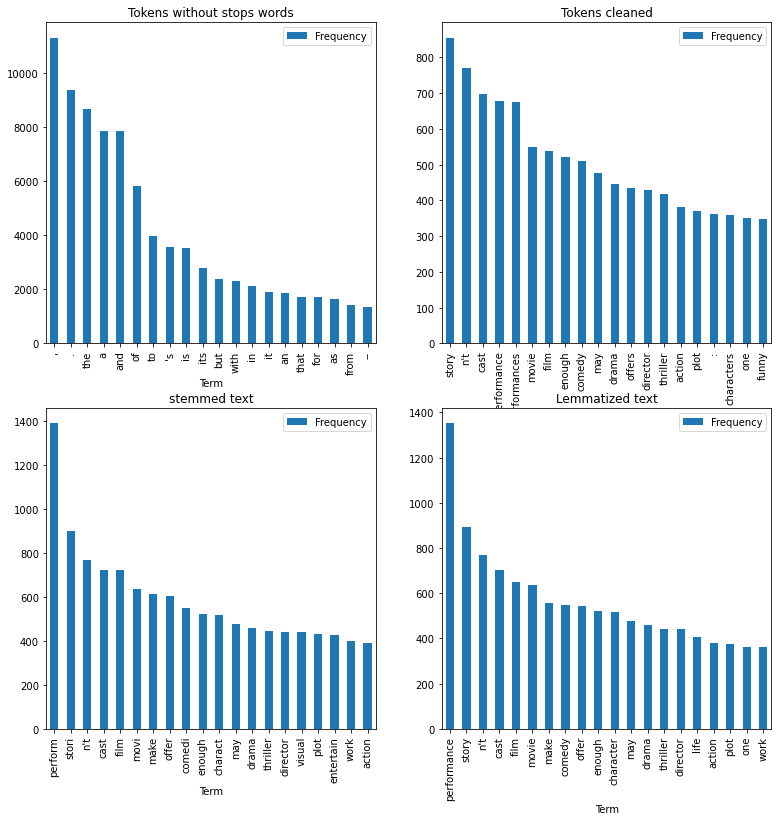

In [39]:
fig = plt.subplots(figsize=(13,13))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

#initial text
df_tokens.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax1)
ax1.set(title="Tokens without stops words")

#after cleaning up stopwords and punctuation
df_words.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax2)
ax2.set(title="Tokens cleaned")

#cleaning up stopwords and punctuation + stemmer
df_stem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax= ax3)
ax3.set(title="stemmed text")

#after cleaning up stopwords and punctuation + lemmatizer.
df_lem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax= ax4)
ax4.set(title="Lemmatized text")


In [40]:
#!conda install -c conda-forge gcc
#!conda install -c conda-forge wordcloud 
# or in command terminal
#import sys
#print(sys.executable)


[Text(0.5, 1.0, 'Lemmatized text')]

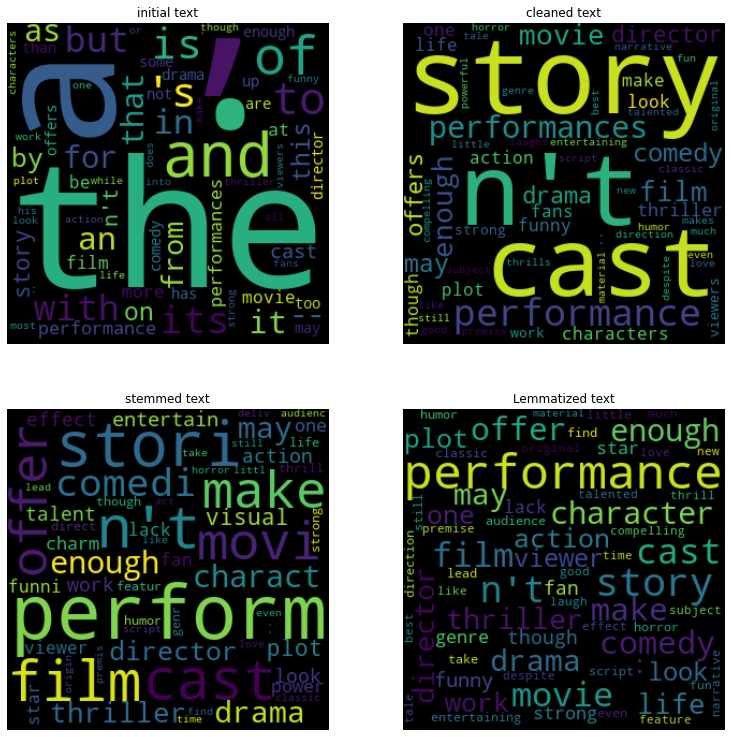

In [41]:
from wordcloud import WordCloud
fig = plt.subplots(figsize=(13,13))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

#initial text
wordcloud1 = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
wordcloud1.generate_from_frequencies(freq)

ax1.imshow(wordcloud1, interpolation="bilinear")
ax1.axis('off')
ax1.set(title="initial text")
plt.margins(x=0, y=0)

#after cleaning up stopwords and punctuation
wordcloud2 = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
wordcloud2.generate_from_frequencies(freq_clean)

ax2.imshow(wordcloud2, interpolation="bilinear")
ax2.axis('off')
ax2.set(title="cleaned text")

#cleaning up stopwords and punctuation + stemmer
wordcloud3 = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
wordcloud3.generate_from_frequencies(nltk.FreqDist(movies[~movies["X_stem"].isna()]["X_stem"].sum()))

ax3.imshow(wordcloud3, interpolation="bilinear")
ax3.axis('off')
ax3.set(title="stemmed text")

#after cleaning up stopwords and punctuation + lemmatizer.
wordcloud4 = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
wordcloud4.generate_from_frequencies(nltk.FreqDist(movies[~movies["X_lem"].isna()]["X_lem"].sum()))

ax4.imshow(wordcloud4, interpolation="bilinear")
ax4.axis('off')
ax4.set(title="Lemmatized text")


In [42]:
#!pip install sklearn

# Create a matrix with vectorise & TF - IDF of any alpha word longer than 2 caracters

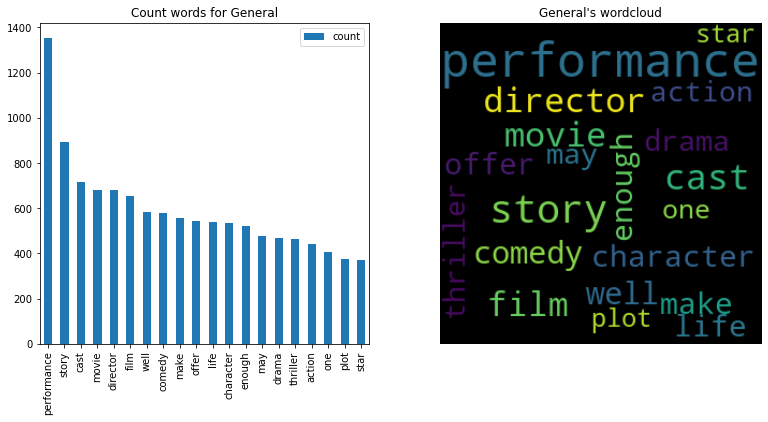

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
def get_count(X, name = "", max_features=20):
    
    vectorizer = CountVectorizer(max_features=max_features, stop_words=stop_words )
    text_matrix = vectorizer.fit_transform(X)

    df_matrix_neg = pd.DataFrame(text_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    df_sum_matrix_neg = pd.DataFrame(df_matrix_neg.sum().sort_values(ascending=False), columns = ["count"])
    
    
    fig = plt.subplots(figsize=(13,13))

    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)

    ax1.set(title=f"Count words for {name}")
    df_sum_matrix_neg.plot(kind="bar", ax = ax1)

    #initial text
    wordcloud_neg = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
    wordcloud_neg.generate_from_frequencies(df_matrix_neg.sum())

    ax2.imshow(wordcloud_neg, interpolation="bilinear")
    ax2.axis('off')
    ax2.set(title=f"{name}'s wordcloud")
    plt.margins(x=0, y=0)    

X = movies[~movies["X_lem"].isna()]["X_lem"].apply(lambda wlist: " ".join(wlist))

get_count(X, name = "General")

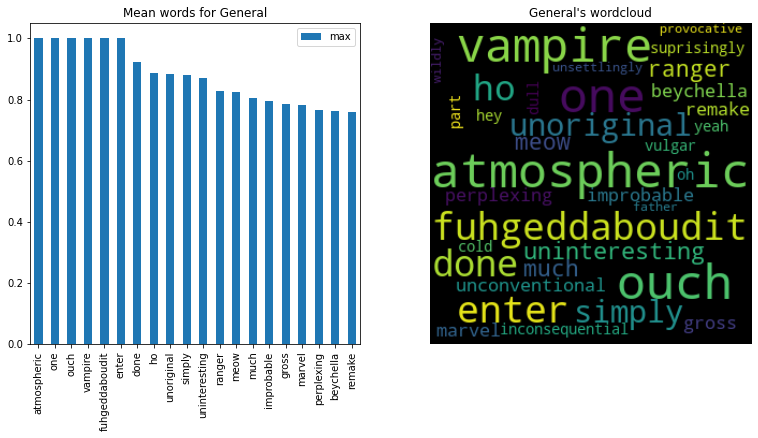

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(X, name = ""):
    tfidf = TfidfVectorizer(token_pattern = "[a-zA-Z]+", stop_words=stop_words)

    #tfidf.fit(X.values)
    text_matrix_tfidf = tfidf.fit_transform(X)
    
    #return text_matrix_tfidf.toarray().shape
    
    df_matrix_tf_idf = pd.DataFrame(text_matrix_tfidf.toarray(), columns = tfidf.get_feature_names_out())
    df_max_tf_idf = pd.DataFrame(df_matrix_tf_idf.max(), columns = ["max"])
    fig = plt.subplots(figsize=(13,13))

    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)

    wordcloud = WordCloud(width=300, height=300, max_font_size=50, min_font_size=10)
    wordcloud.generate_from_frequencies(df_matrix_tf_idf.max().sort_values(ascending=False).head(40))

    ax2.imshow(wordcloud, interpolation="bilinear")
    ax2.axis('off')
    plt.margins(x=0, y=0)

    df_max_tf_idf.sort_values("max", ascending=False).head(20).plot(kind="bar", ax = ax1)
    
    ax1.set(title=f"Mean words for {name}")
    ax2.set(title=f"{name}'s wordcloud")
    
X = movies["X_lem"].apply(lambda wlist: " ".join(wlist))
get_tfidf(X, name = "General")


In [45]:
#movies["X_lem"]"atmospheric" .explode().value_counts()
print(X[X.str.contains("performance")].count())
print(X.sum().count("performance"))


1350
1353


# Most frequent words depend of tomatometer status

In [46]:
#X = movies[(~movies["X_lem"] movies['tomatometer_status'] == "Rotten")]["X_lem"].apply(lambda wlist: " ".join(wlist))    
#get_count(X, "Rotten")

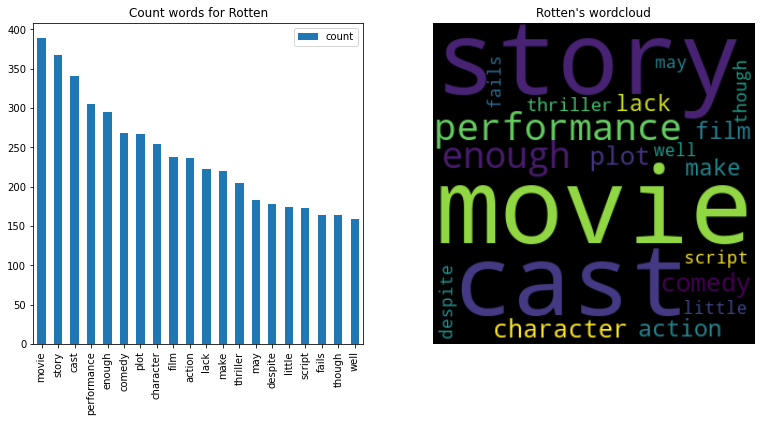

In [53]:
X = movies[(~movies["X_lem"].isna()) & (movies['tomatometer_status'] == "Rotten")]["X_lem"].apply(lambda wlist: " ".join(wlist))    
get_count(X, "Rotten")

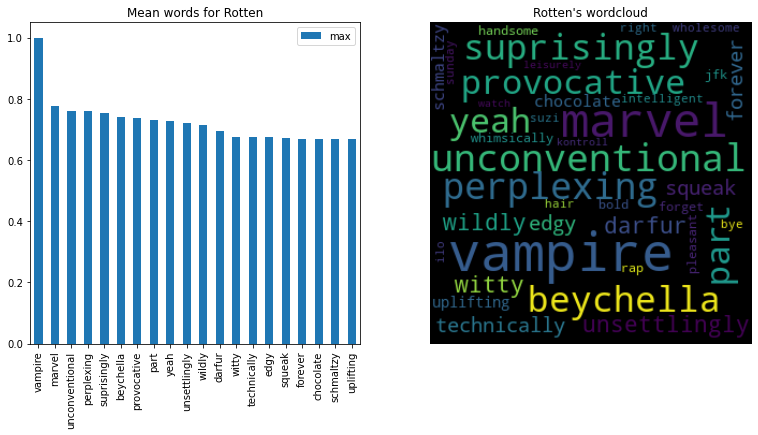

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = movies[(~movies["X_lem"].isna()) & (movies['tomatometer_status'] != "Rotten")]["X_lem"].apply(lambda wlist: " ".join(wlist))
get_tfidf(X, name = "Rotten")

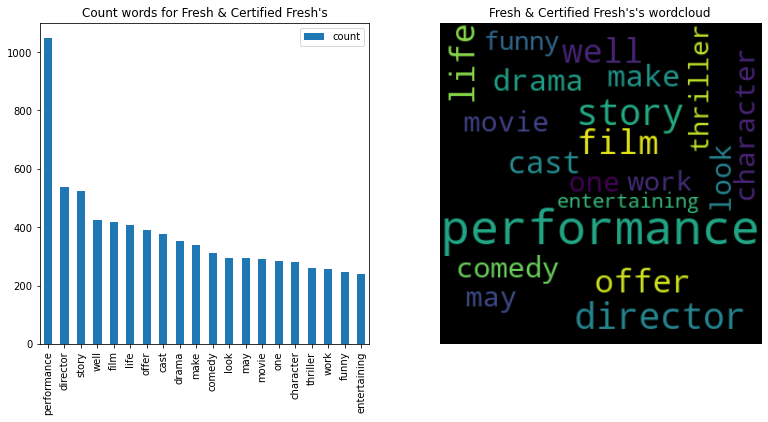

In [49]:
X = movies[(~movies["X_lem"].isna()) & (movies['tomatometer_status'] != "Rotten")]["X_lem"].apply(lambda wlist: " ".join(wlist))
get_count(X, "Fresh & Certified Fresh's")

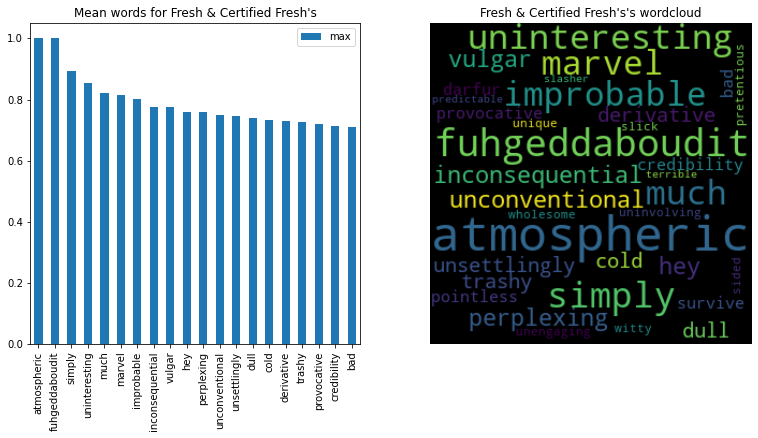

In [58]:
get_tfidf(X, "Fresh & Certified Fresh's")

# Count & TF IDF per genre

/var/folders/ts/l4jvqvn135g1lpkckf7t5cmc0000gn/T/ipykernel_5319/923809997.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.subplots(figsize=(13,13))


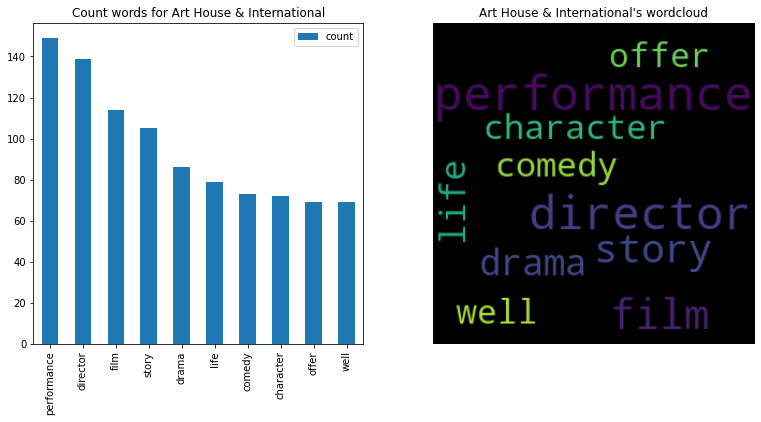

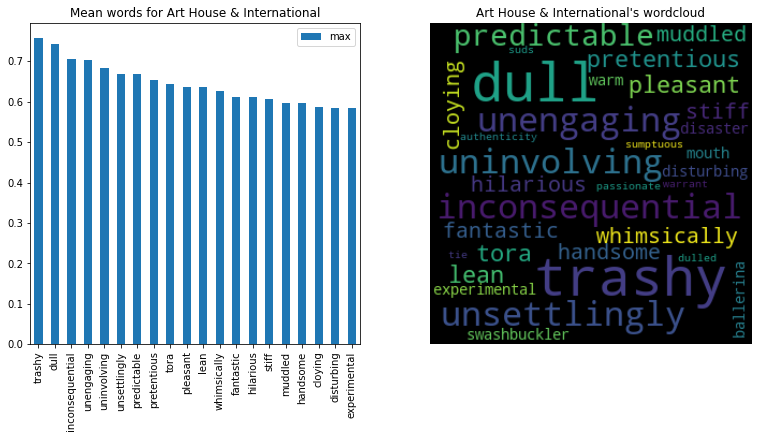

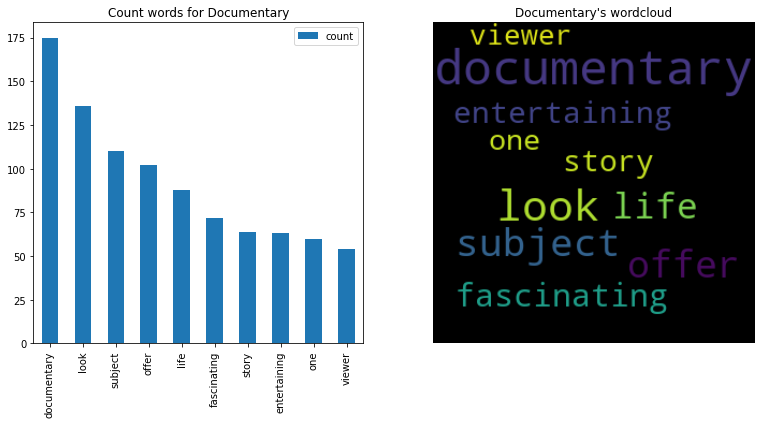

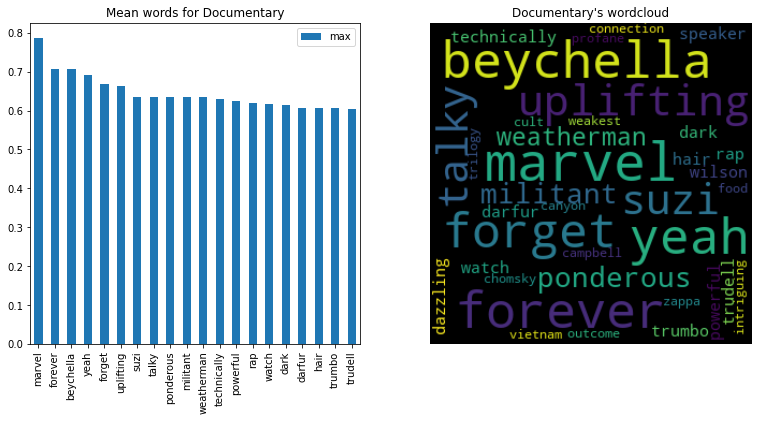

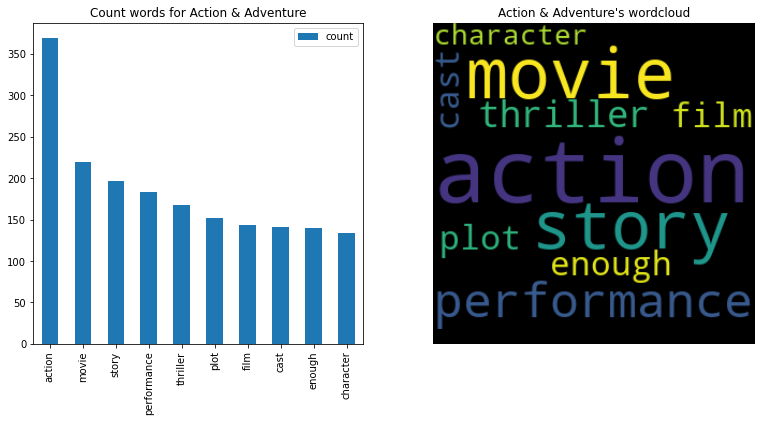

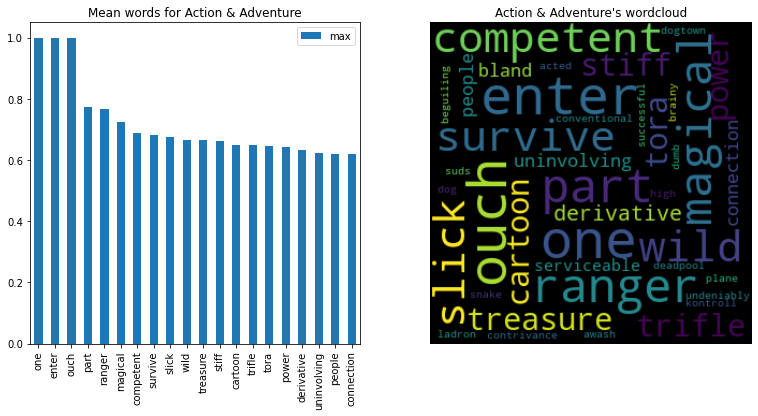

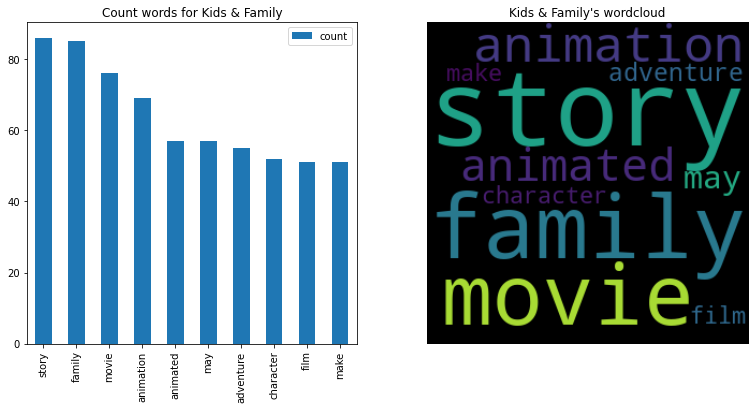

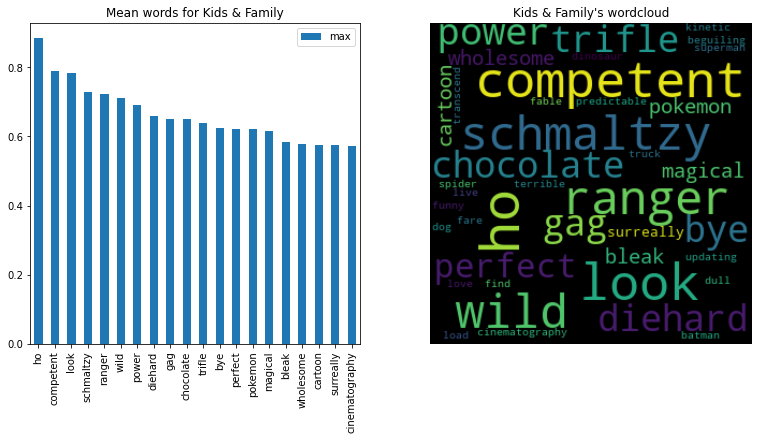

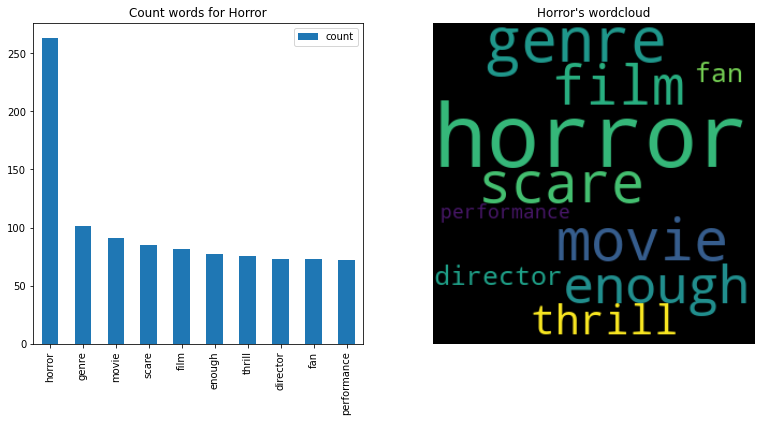

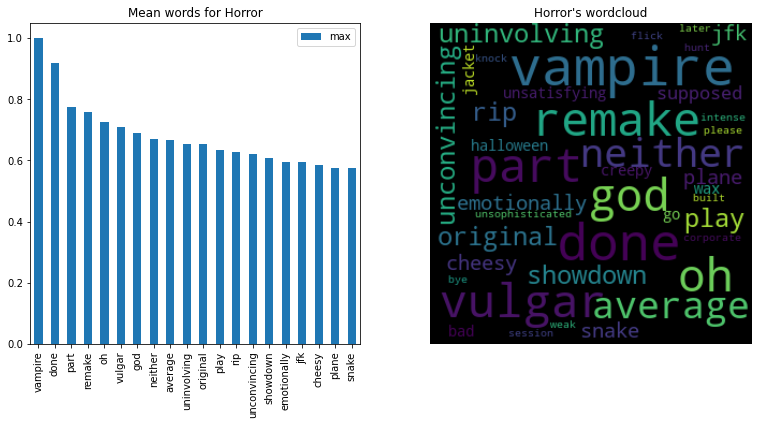

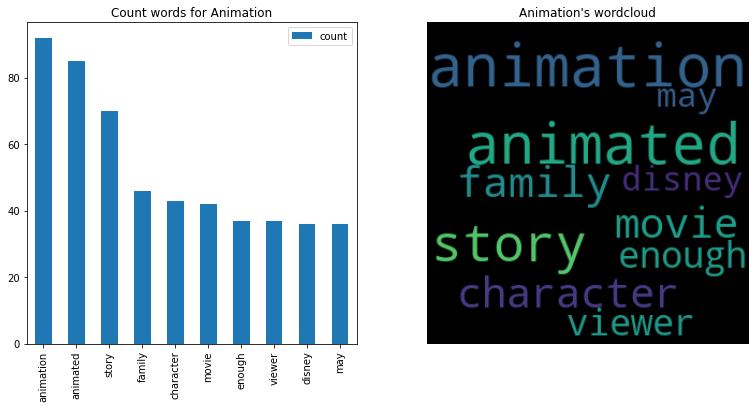

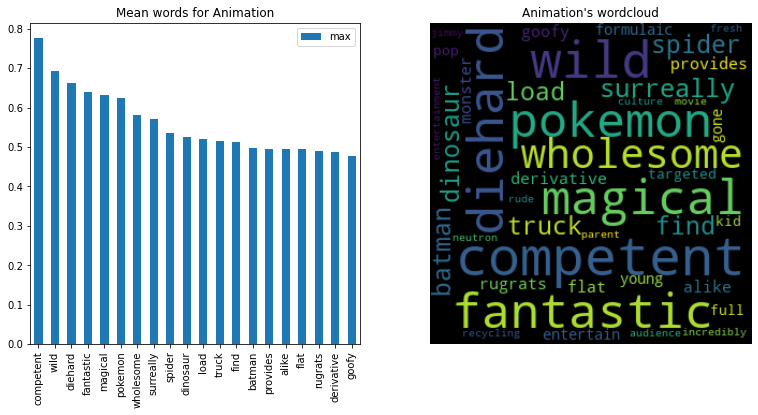

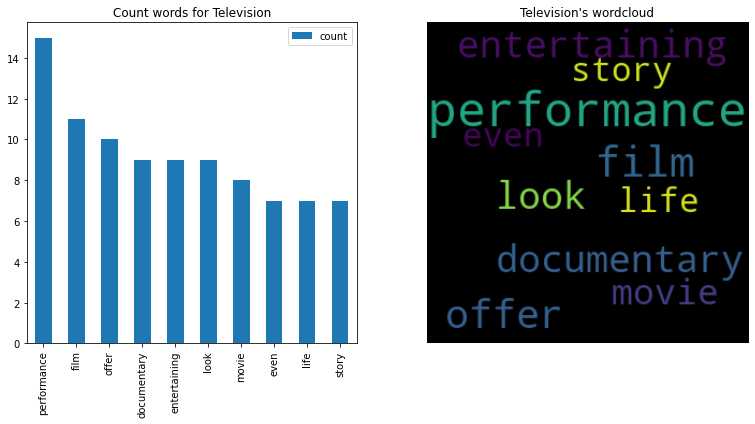

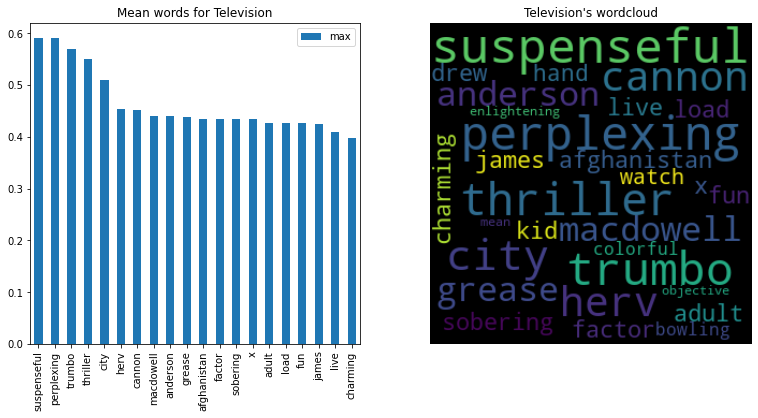

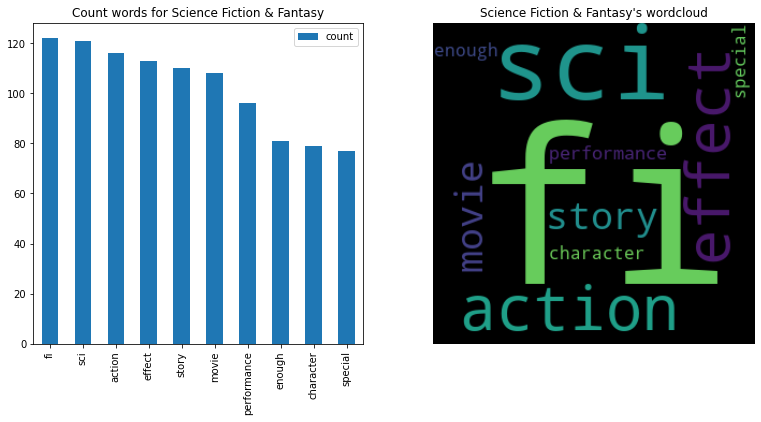

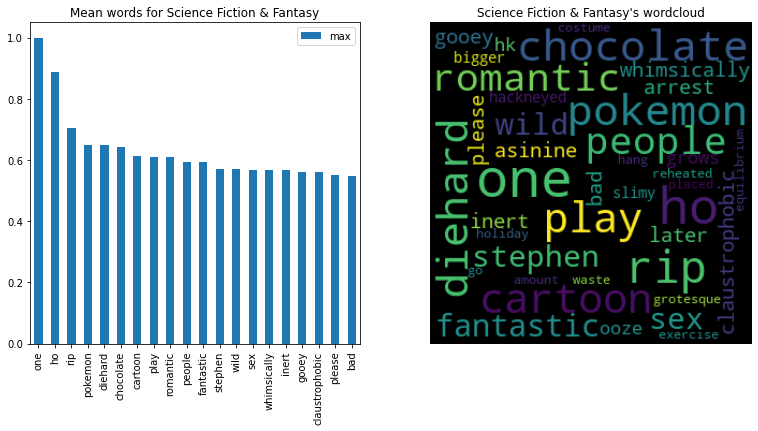

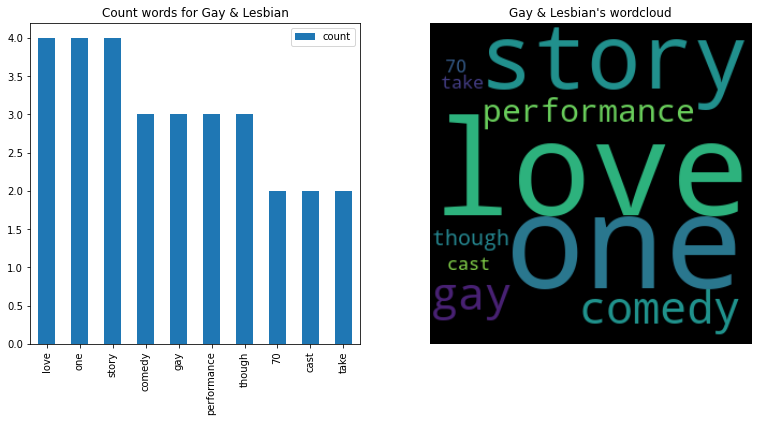

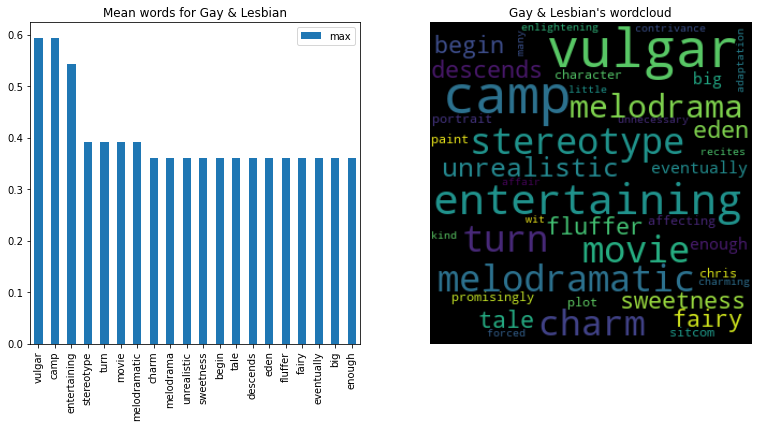

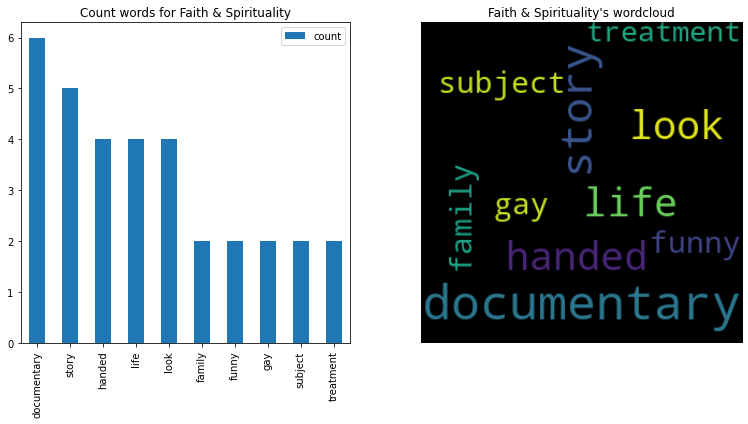

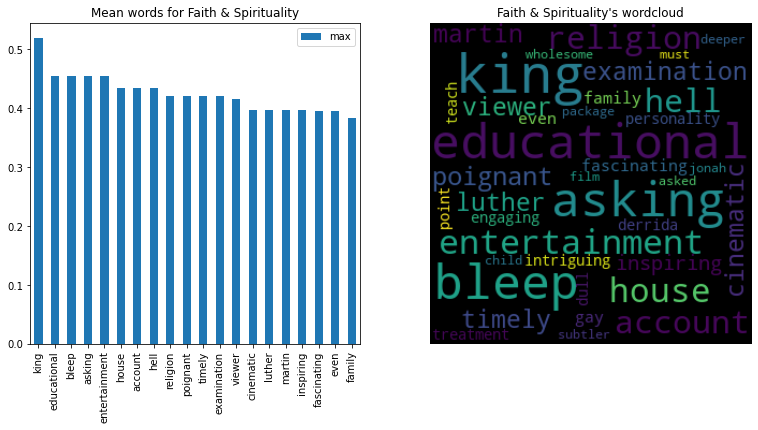

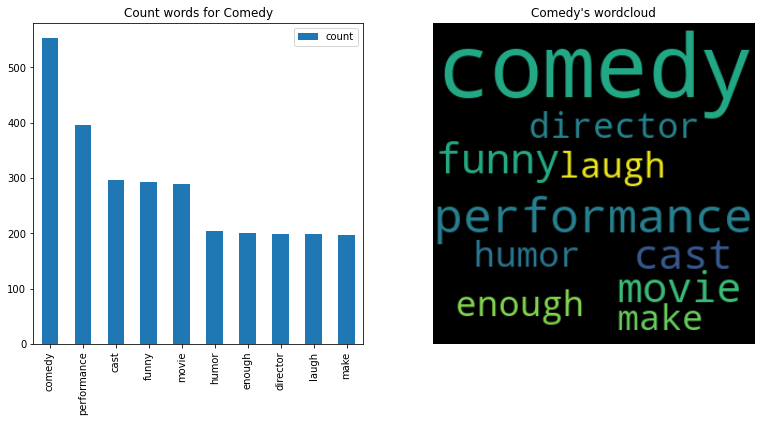

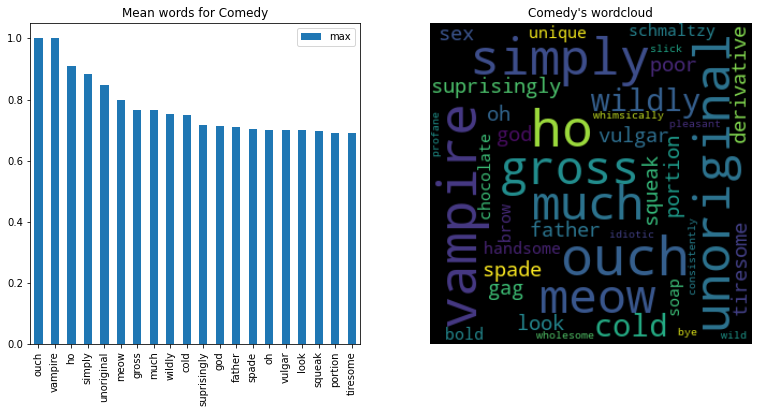

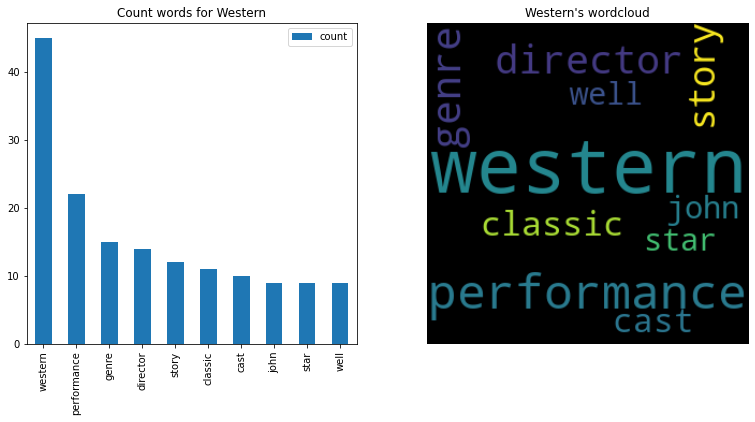

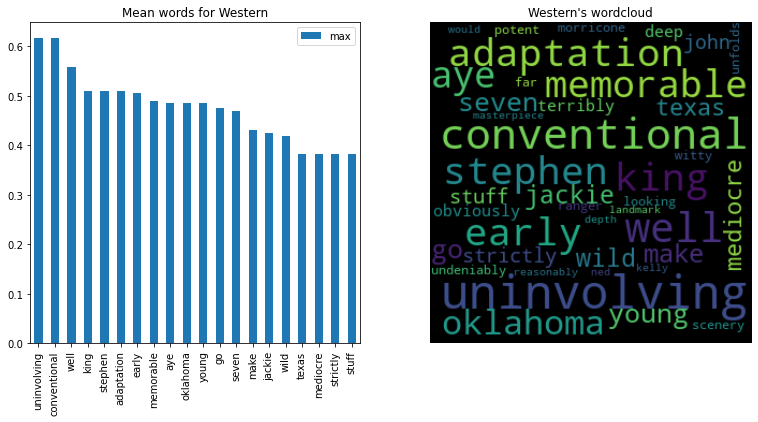

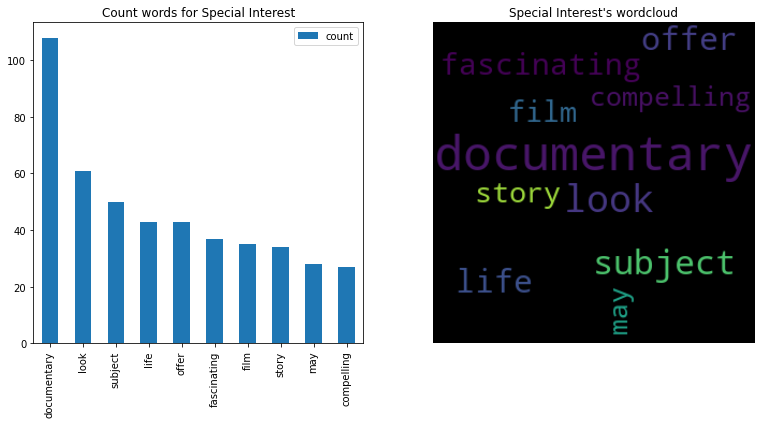

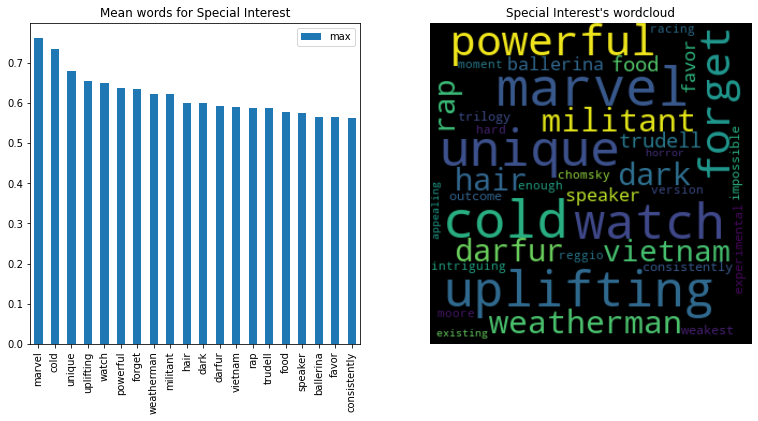

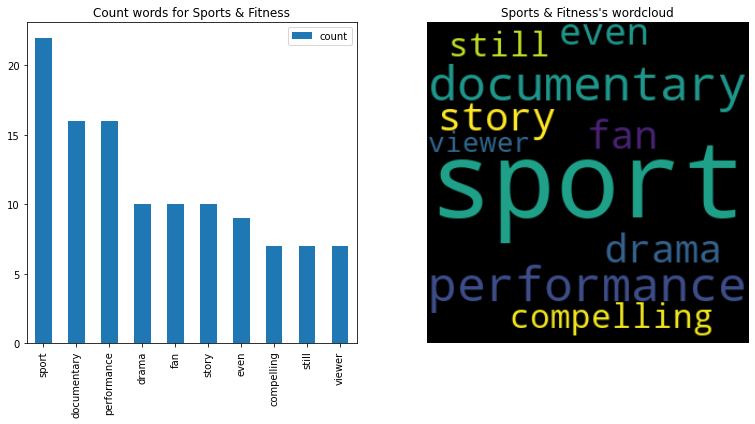

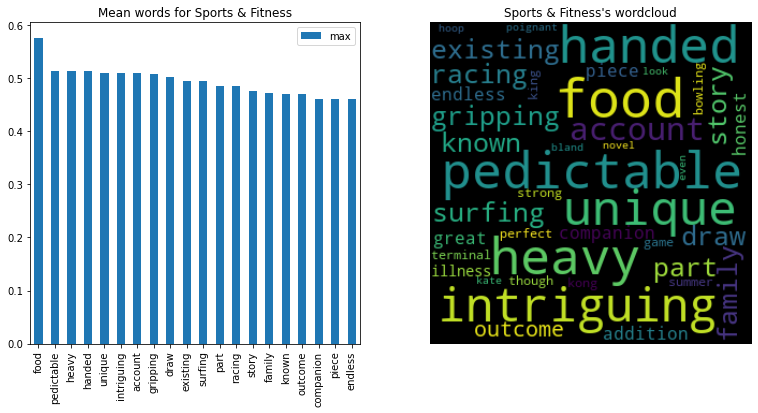

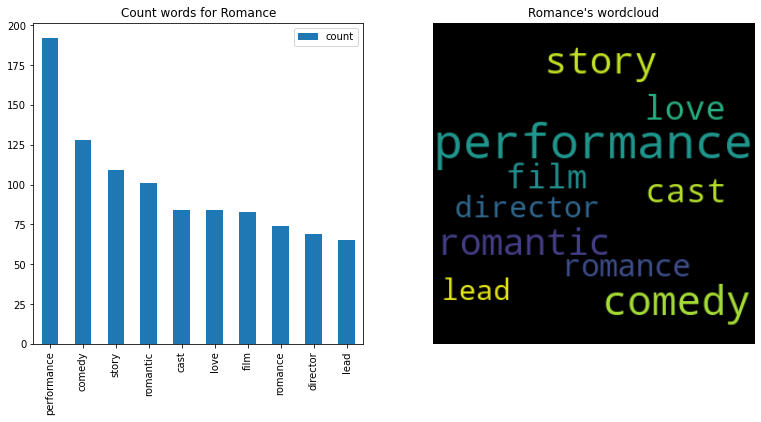

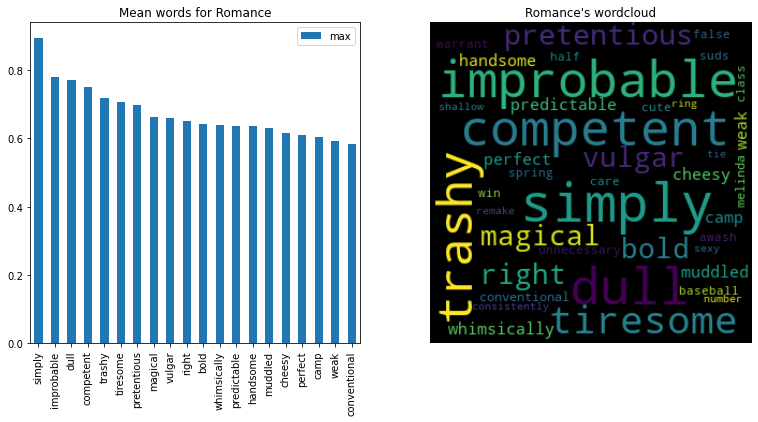

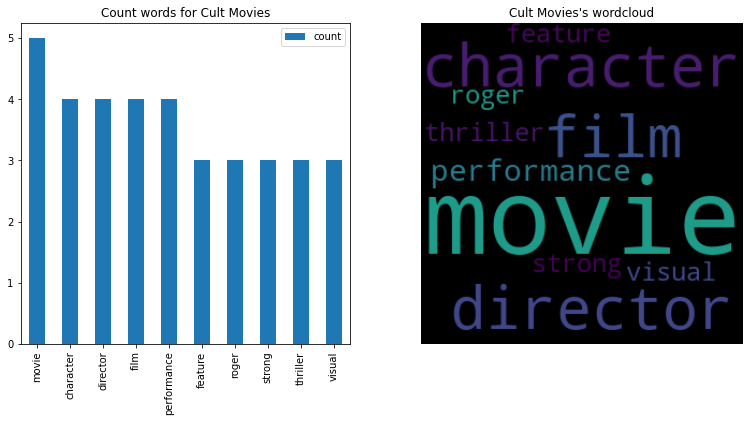

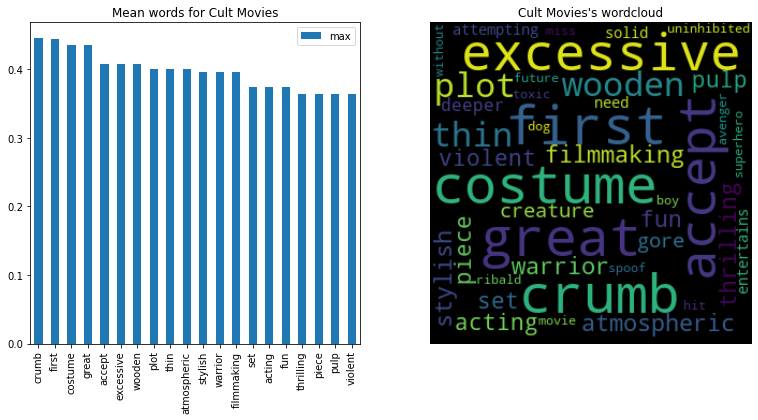

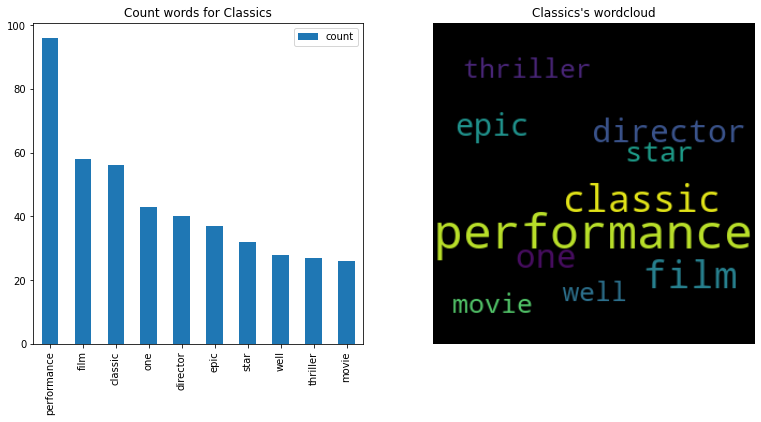

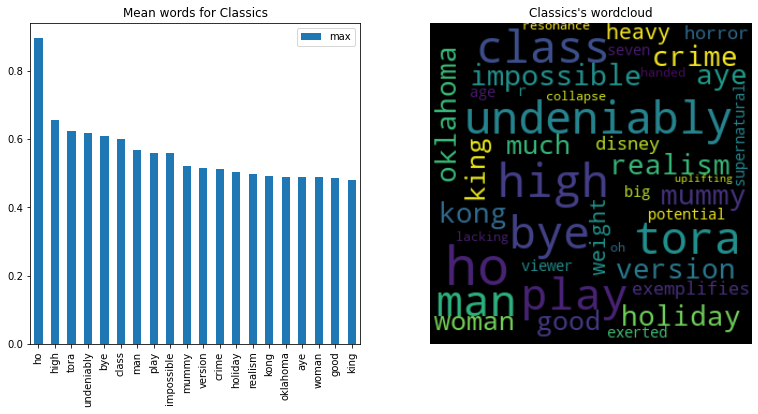

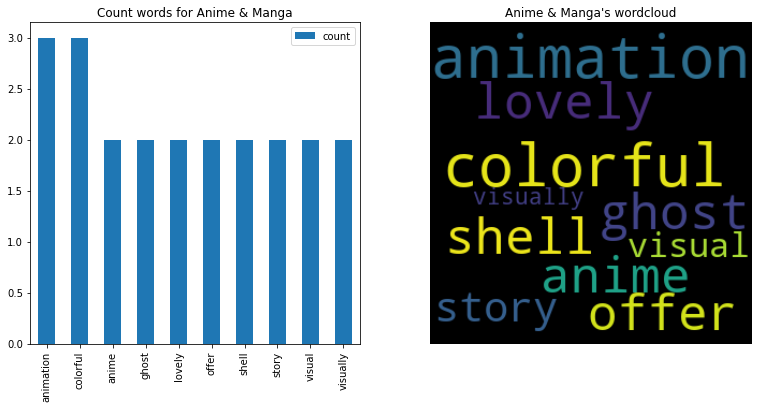

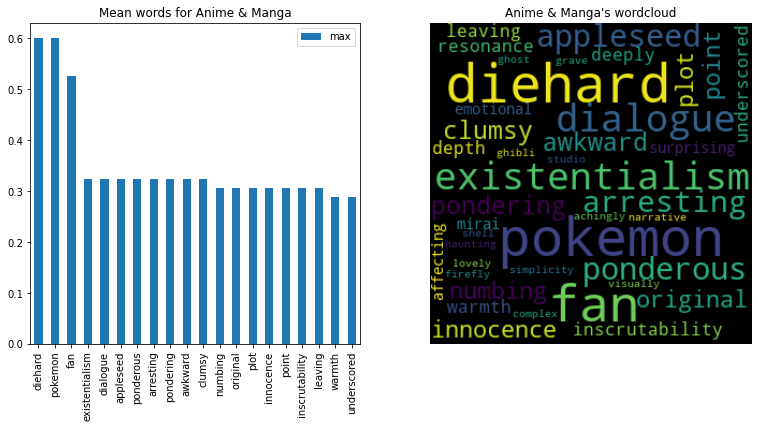

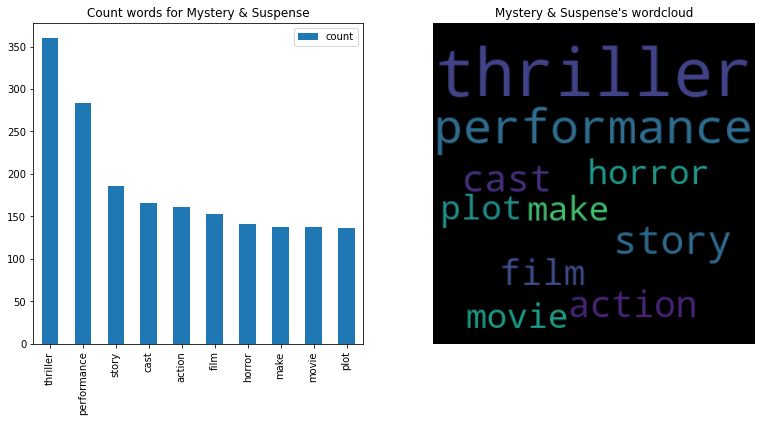

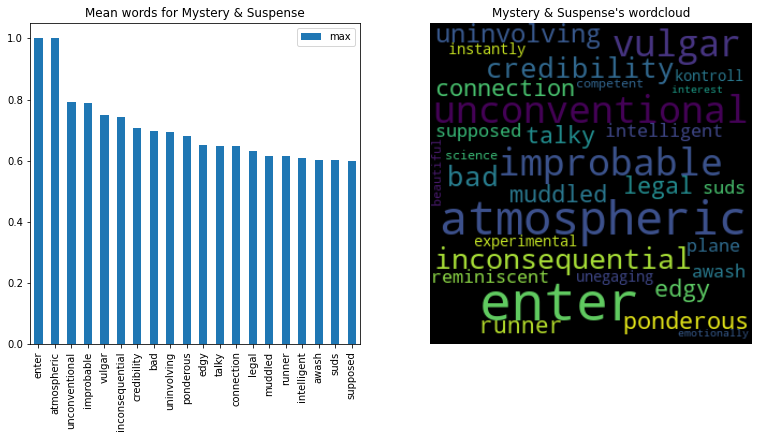

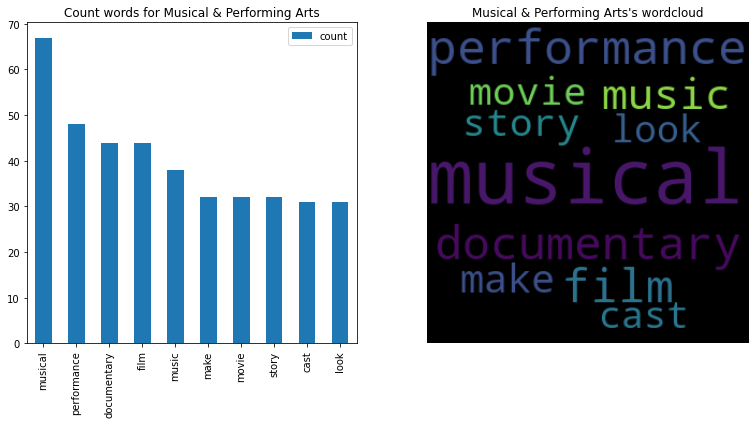

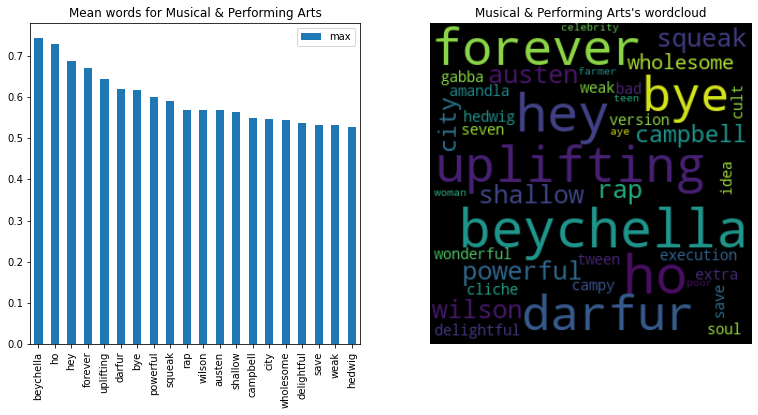

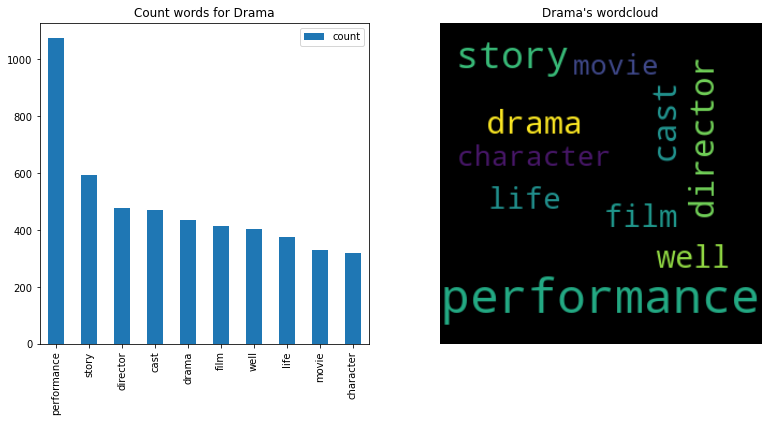

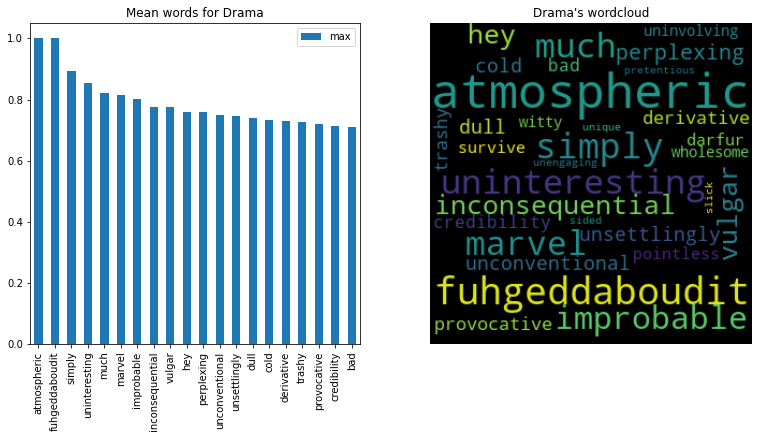

In [57]:
to_list = lambda string: string.split(", ") if type(string) == str else []

list_genres = set(movies["genres"].sum())
df_movies_explodes = movies.explode(["genres"])
for genre in list_genres:
    X = df_movies_explodes[(~df_movies_explodes["X_lem"].isna()) & (df_movies_explodes["genres"].str.contains(genre))]["X_lem"].apply(lambda wlist: " ".join(wlist))
    get_count(X, genre, 10)
    get_tfidf(X, genre)


# Analyse audience comments

In [ ]:
from ast import literal_eval
#critic_reviews["tokens"] =  critic_reviews[critic_reviews['review_content'].isna() != True]['review_content'].apply(lambda sentence: [w.lower() for w in nltk.word_tokenize(sentence)])
get_tokens_list = lambda x: literal_eval(x) if type(x) == str else []
#critic_reviews["tokens"] =  critic_reviews["tokens"].apply(lambda sentence: [w.split(",") for w in sentence if type(sentence) == str])
#critic_reviews["tokens"].apply(get_tokens_list)
critic_reviews["tokens"] = critic_reviews["tokens"].apply(get_tokens_list)
#type(critic_reviews.at[0, "tokens"])

In [ ]:
#critic_reviews.to_csv('rotten_tomatoes_critic_reviews_tokens_light.csv', columns=["rotten_tomatoes_link","critic_name","publisher_name","tokens"])
#movies.to_csv('rotten_tomatoes_movies_with_nlp.csv')

In [ ]:
df_tokens_per_movies = pd.pivot_table(critic_reviews[["rotten_tomatoes_link","tokens"]], values=["tokens"], index=['rotten_tomatoes_link'], aggfunc={"tokens": sum})
df_tokens_per_movies.reset_index(inplace=True)

In [ ]:
#df_tokens_per_movies.columns = ["rotten_tomatoes_link", "tokens"]
df_tokens_per_movies

In [ ]:
#critic_reviews["tokens"] =  critic_reviews[critic_reviews['tokens'].isna() != True]['tokens'].apply(lambda sentence: [w.lower() for w in nltk.word_tokenize(sentence)])
#cleaning_tokens = lambda tokens: [ str(w) for w in tokens if str(w) not in nltk.corpus.stopwords.words("english") ] if isinstance(tokens, list) else []
#df_tokens_per_movies["X_clean"] = df_tokens_per_movies[~df_tokens_per_movies["tokens"].isna()]["tokens"].apply(cleaning_tokens)

In [ ]:
#df_tokens_per_movies["X_stem"] = df_tokens_per_movies[~df_tokens_per_movies["X_clean"].isna()]["X_clean"].apply(lambda words: [porter.stem(word.lower()) for word in words] )
#df_tokens_per_movies["X_lem"] = df_tokens_per_movies[~df_tokens_per_movies["X_clean"].isna()]["X_clean"].apply(lambda words: [wnl.lemmatize(word.lower()) for word in words] )

In [ ]:
#df_tokens_per_movies.to_csv('df_reviews_tokens_per_movies.csv')
#df_reviews_tokens_per_movies.csv
link = "./df_reviews_tokens_per_movies.csv"
df_tokens_per_movies = pd.read_csv(link, nrows= 2000, converters={\
                                                    'tokens': get_tokens_list,\
                                                    'X_lem': get_tokens_list,\
                                                   'X_stem': get_tokens_list,\
                                                  'X_clean': get_tokens_list})



In [ ]:
df_tokens_per_movies_sample = df_tokens_per_movies.sample(n=1000, random_state=1)
df_tokens_per_movies_sample['X_clean'] = df_tokens_per_movies_sample['X_clean'].apply(lambda data: [w for w in data if not w in '[]()"",.'])
df_tokens_per_movies_sample['X_stem'] = df_tokens_per_movies_sample['X_stem'].apply(lambda data: [w for w in data if not w in '[]()"",.'])
df_tokens_per_movies_sample['X_lem'] = df_tokens_per_movies_sample['X_lem'].apply(lambda data: [w for w in data if not w in '[]()"",.'])

In [ ]:
df_tokens_per_movies_sample.head()

In [ ]:
fig = plt.subplots(figsize=(13,13))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

df_audience_tokens = pd.DataFrame.from_dict(nltk.FreqDist(df_tokens_per_movies_sample[df_tokens_per_movies_sample["tokens"].isna() == False]["X_lem"].sum()), orient='index')
df_audience_tokens.columns = ['Frequency']
df_audience_tokens.index.name = 'Term'

df_audience_clean = pd.DataFrame.from_dict(nltk.FreqDist(df_tokens_per_movies_sample[df_tokens_per_movies_sample["X_clean"].isna() == False]["X_lem"].sum()), orient='index')
df_audience_clean.columns = ['Frequency']
df_audience_clean.index.name = 'Term'

df_audience_stem = pd.DataFrame.from_dict(nltk.FreqDist(df_tokens_per_movies_sample[df_tokens_per_movies_sample["X_stem"].isna() == False]["X_lem"].sum()), orient='index')
df_audience_stem.columns = ['Frequency']
df_audience_stem.index.name = 'Term'

df_audience_lem = pd.DataFrame.from_dict(nltk.FreqDist(df_tokens_per_movies_sample[df_tokens_per_movies_sample["X_lem"].isna() == False]["X_lem"].sum()), orient='index')
df_audience_lem.columns = ['Frequency']
df_audience_lem.index.name = 'Term'

#initial text
df_audience_tokens.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax1)
ax1.set(title="Tokens without stops words")

#after cleaning up stopwords and punctuation
df_audience_clean.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax = ax2)
ax2.set(title="Tokens cleaned")

#cleaning up stopwords and punctuation + stemmer
df_audience_stem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax= ax3)
ax3.set(title="stemmed text")

#after cleaning up stopwords and punctuation + lemmatizer.
df_audience_lem.sort_values(['Frequency'], ascending=False).head(20).plot(kind="bar", ax= ax4)
ax4.set(title="Lemmatized text")

In [ ]:
X = df_tokens_per_movies_sample["X_lem"].apply(lambda wlist: " ".join(wlist))

get_count(X, "Reviews", 20)
get_tfidf(X, "Reviews", 20)


In [ ]:
def analyse_reviews(X,name = "Reviews",max_features= 20,regex_pattern = "([a-zA-Z]{2,})",stop_words=["film", "movie", "one"]):
    vectorizer = CountVectorizer(token_pattern=regex_pattern, max_features=max_features,stop_words=stop_words)

    vectorizer.fit(X.values)
    text_matrix = vectorizer.fit_transform(X)

    df_matrix_neg = pd.DataFrame(text_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    df_sum_matrix_neg = pd.DataFrame(df_matrix_neg.sum().sort_values(ascending=False), columns = ["count"])
    fig = plt.subplots(figsize=(13,13))

    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)

    ax1.set(title=f"Count words for {name}")
    df_sum_matrix_neg.plot(kind="bar", ax = ax1)

    #initial text
    wordcloud_neg = WordCloud(width=300, height=300, max_font_size=200, min_font_size=10)
    wordcloud_neg.generate_from_frequencies(df_matrix_neg.sum())

    ax2.imshow(wordcloud_neg, interpolation="bilinear")
    ax2.axis('off')
    ax2.set(title=f"{name}'s wordcloud")
    plt.margins(x=0, y=0)
analyse_reviews(X)